# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [4]:
import torch
import numpy as np
from torch import nn

from tqdm import tqdm_notebook as tqdm  # because I love progress bars
import time
from typing import List, Iterable, Tuple

from utils import SkipGramDataGen, Vocab, preprocess

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
class SkipGram(nn.Module):
    """
    Implementing naive skip-gram with naive softmax and all that.
    """
    def __init__(self, vocab_size: int, emb_size: int):
        super(SkipGram, self).__init__()
        self.emb = nn.Linear(vocab_size + 1, emb_size)
        self.out = nn.Linear(emb_size, vocab_size + 1)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x, y):
        logits = self.out(self.emb(x))
        loss = self.loss_fn(logits, y)
        return loss

In [3]:
with open("text8/text8", encoding="utf-8") as f:
    tokens = preprocess(f.read())

In [4]:
# training parameters go here
vocab_size = 30000
window_size = 5
emb_size = 150
batch_size = 256
n_epochs = 3

lr = 3e-4

In [5]:
vocab = Vocab(vocab_size)

In [6]:
vocab.build([tokens])

In [7]:
data = SkipGramDataGen([vocab.numericalize(tokens)], window_size)

These results are obtained on a GTX 1050Ti with 4Gb of video RAM.

In [8]:
device = torch.device("cuda")

In [9]:
model = SkipGram(vocab_size, emb_size)

In [10]:
model.to(device)

SkipGram(
  (emb): Linear(in_features=30001, out_features=150, bias=True)
  (out): Linear(in_features=150, out_features=30001, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [11]:
def epoch(model: nn.Module, 
          data: SkipGramDataGen, 
          loss_history: List, 
          optimizer, 
          device, 
          bs=128, 
          report_every=3000):
    """
    Run one epoch of training the `model` on `data`.
    Loss values for plotting are saved in `loss_history`.
    Average batch loss is printed every `report_every` epochs.
    """
    start = time.time()
    running_loss = list()
    for i, (x, y) in enumerate(tqdm(data.iter_batch(bs))):
        optimizer.zero_grad()
        x_onehot = torch.zeros((len(x), vocab_size + 1), dtype=torch.float)
        for b_i, x_i in enumerate(x):
            x_onehot[b_i, x_i] = 1
        x = x_onehot.to(device)
        # x = torch.tensor(x, dtype=torch.long).to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)
        loss = model.forward(x, y)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.detach().item())
        if (i + 1) % report_every == 0:
            avg_loss = sum(running_loss) / len(running_loss)
            print("Step {}, loss: {}".format(i + 1, avg_loss))
            loss_history.append(avg_loss)
            running_loss = list()
    print("Done. Time: {}. Loss: {}.".format(time.time() - start, sum(running_loss) / len(running_loss)))

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
loss_history = list()

In [14]:
for i in range(n_epochs):
    print("Epoch", i)
    epoch(model, data, loss_history, optimizer, device, bs=batch_size)

Epoch 0


Step 3000, loss: 7.3875992093086245
Step 6000, loss: 6.96267570622762
Step 9000, loss: 7.052875632286072
Step 12000, loss: 7.0497058819135034
Step 15000, loss: 7.0228128088315325
Step 18000, loss: 7.077516728242238
Step 21000, loss: 7.127617728392283
Step 24000, loss: 7.10609037399292
Step 27000, loss: 7.021129311482111
Step 30000, loss: 7.043087442398071
Step 33000, loss: 7.038518836100896
Step 36000, loss: 7.027354205528895
Step 39000, loss: 7.007112335443496
Step 42000, loss: 7.048216515223185
Step 45000, loss: 7.029642133792241
Step 48000, loss: 7.006302008549373
Step 51000, loss: 6.771427016099294
Step 54000, loss: 6.91207991528511
Step 57000, loss: 7.0006279705365495
Step 60000, loss: 7.051611096223195
Step 63000, loss: 6.884435428937276
Step 66000, loss: 6.958953229824702

Done. Time: 3123.1942486763. Loss: 7.16827058010414.
Epoch 1


Step 3000, loss: 6.988901832262675
Step 6000, loss: 6.872721696853637
Step 9000, loss: 6.975963743448258
Step 12000, loss: 6.974260469436645
Step 15000, loss: 6.966116192499797
Step 18000, loss: 6.996663290023804
Step 21000, loss: 7.052081636110942
Step 24000, loss: 7.038831893444061
Step 27000, loss: 6.949404897530874
Step 30000, loss: 6.972270074367523
Step 33000, loss: 6.967763838132223
Step 36000, loss: 6.967416904767354
Step 39000, loss: 6.933726919253667
Step 42000, loss: 6.970297854185104
Step 45000, loss: 6.958287430604299
Step 48000, loss: 6.936696256160736
Step 51000, loss: 6.700063368479411
Step 54000, loss: 6.860762179454167
Step 57000, loss: 6.928713483015696
Step 60000, loss: 6.9948604563077295
Step 63000, loss: 6.814509209314982
Step 66000, loss: 6.892656874895096

Done. Time: 3983.234877347946. Loss: 7.107855239573351.
Epoch 2


Step 3000, loss: 6.922785405000051
Step 6000, loss: 6.807762603680293
Step 9000, loss: 6.917263747771581
Step 12000, loss: 6.903588323752086
Step 15000, loss: 6.907381263017655
Step 18000, loss: 6.9175908846855165
Step 21000, loss: 6.978418636480967
Step 24000, loss: 6.991267552057902
Step 27000, loss: 6.895314680814743
Step 30000, loss: 6.912605131467183
Step 33000, loss: 6.915523424069087
Step 36000, loss: 6.906367408911387
Step 39000, loss: 6.879586743513743
Step 42000, loss: 6.923332055091858
Step 45000, loss: 6.916536564032237
Step 48000, loss: 6.893017053206762
Step 51000, loss: 6.659048312028249
Step 54000, loss: 6.812969190518062
Step 57000, loss: 6.886317849636078
Step 60000, loss: 6.945779188632965
Step 63000, loss: 6.766832848946254
Step 66000, loss: 6.85806586432457

Done. Time: 3296.429037094116. Loss: 7.083130708064631.


In [22]:
torch.save(model.state_dict(), "task_3.pth")

In [25]:
def get_embeddings(model: nn.Module, mode: str="first"):
    """
    Get the embeddings from the model. Supported modes are:
    `first`: embeddings from the first layer
    `second`: embeddings from the (surprise!) second layer
    `average`: embeddings from both the layers, averaged.
    """
    if mode == "first":
        return model.emb.weight.data.clone().detach().t().cpu().numpy()
    if mode == "second":
        return model.out.weight.data.clone().detach().cpu().numpy()
    if mode == "average":
        return (model.emb.weight.data.clone().detach().t().cpu().numpy() + \
            model.out.weight.data.clone().detach().cpu().numpy()) / 2

### 1. Trained word vectors 

As seen from the logs above, it took almost **three hours** to train!

In [26]:
embeddings = get_embeddings(model, "average")

In [27]:
embeddings.shape

(30001, 150)

Let's save them for later:

In [42]:
np.save("embeddings.np", embeddings)

In [45]:
import pickle

with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab.itos, f)

### 2. Plotted loss

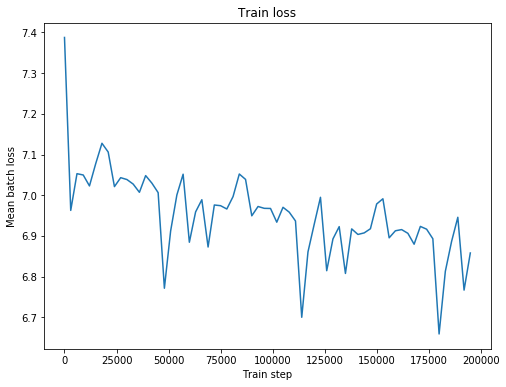

In [140]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=[3000*i for i in range(len(loss_history))], y=loss_history)
plt.title("Train loss")
plt.ylabel("Mean batch loss")
plt.xlabel("Train step")
plt.show()

### 3. Function to map token to corresponding word vector

In [40]:
def get_vector(word: str, vocab: Vocab, embeddings: np.array):
    assert word in vocab.stoi, "Word is not in the vocabulary"
    i = vocab.stoi[word]
    vec = embeddings[i]
    return vec

In [46]:
get_vector("russia", vocab, embeddings).shape

(150,)

### 4. Beautiful visualizations (PCE, T-SNE)

In [18]:
def most_similar(word: str, vocab: Vocab, embeddings: np.array, n_similar: int) -> List[Tuple[str, int]]:
    assert word in vocab.stoi, "Word is not in the vocabulary"
    i = vocab.stoi[word]
    vec = embeddings[i]
    # cosine similarity measure:
    sims = embeddings @ vec.T \
        / (np.sqrt(np.sum(np.square(embeddings), axis=1)) \
           * np.sqrt(np.sum(np.square(vec)))) 
    i_to_sim = zip(vocab.itos, sims)
    words_by_sim = sorted(i_to_sim, key=lambda x: x[1], reverse=True)
    return list(words_by_sim)[:n_similar]

T-SNE is a pain to do even on a matrix of this size.

In [52]:
from sklearn.decomposition import PCA

In [69]:
pca = PCA(2)
pca.fit(embeddings)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [108]:
def visualize(embeddings, vocab, words, num_neihgbors, pca):
    clusters = list()
    for word in words:
        clusters.append(most_similar(word, vocab, embeddings, num_neihgbors))

    vectors, labels, sims, hues = list(), list(), list(), list()
    for i, cluster in enumerate(clusters):
        for w, s in cluster:
            vectors.append(get_vector(w, vocab, embeddings))
            labels.append(w)
            sims.append(s)
            hues.append(i)

    transformed = pca.transform(np.stack(vectors))
    
    return transformed[:, 0], transformed[:, 1], labels, sims, hues

In [136]:
words_to_vis = ["cat", "russia", "scientist"]

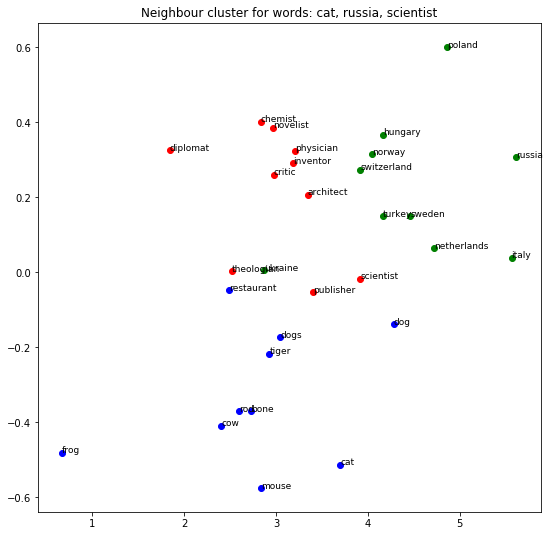

In [137]:
x, y, labels, sims, hues = visualize(embeddings, vocab, words_to_vis, 10, pca)

plt.figure(figsize=(9, 9))
plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # this is how many clusters you can get
offs = 0.02

for i in range(len(labels)):
    plt.scatter(x[i], y[i], c=plt_colors[hues[i]])
    plt.text(x[i] + offs, y[i] + offs, labels[i], fontsize=9)

plt.title(f"Neighbour cluster for words: {', '.join(words_to_vis)}")
plt.show()

Apart from restaurant somehow being similar to cat, looks fine!

### 5. Qualitative evaluations of word vectors: nearest neighbors, word analogies

In [16]:
def most_similar_to_vec(vec, vocab, embeddings, n_similar):
    sims = embeddings @ vec.T \
        / (np.sqrt(np.sum(np.square(embeddings), axis=1)) \
           * np.sqrt(np.sum(np.square(vec)))) 
    i_to_sim = zip(vocab.itos, sims)
    words_by_sim = sorted(i_to_sim, key=lambda x: x[1], reverse=True)
    return list(words_by_sim)[:n_similar]

def solve_analogy(embeddings: np.ndarray, vocab: Vocab, task: List[str]) -> Tuple[str, float]:
    """
    Return the word d from `a to b is like c to d`, given a, b, c in the task list
    """
    indices = [vocab.stoi[w] for w in task]
    vectors = embeddings[indices]
    query = vectors[1] - vectors[0] + vectors [2]
    closest = most_similar_to_vec(query, vocab, embeddings, 4)
    for c in closest:
        if c[0] not in task:
            return c

#### Nearest neighbours 

In [202]:
most_similar("russia", vocab, embeddings, 10)

[('russia', 1.0),
 ('poland', 0.9163953),
 ('turkey', 0.90022814),
 ('hungary', 0.89238894),
 ('ukraine', 0.890954),
 ('italy', 0.8897804),
 ('switzerland', 0.88882756),
 ('netherlands', 0.88637286),
 ('norway', 0.8860279),
 ('sweden', 0.88526994)]

Word2vec is always good at countries.

In [203]:
most_similar("table", vocab, embeddings, 10)

[('table', 1.0000001),
 ('periodic', 0.91867024),
 ('sequence', 0.904523),
 ('diagram', 0.9040695),
 ('graph', 0.8997405),
 ('sample', 0.8967556),
 ('continuous', 0.8954403),
 ('corresponding', 0.8946259),
 ('dimension', 0.89257026),
 ('binary', 0.8907469)]

Here we see that the embeddings are trained on Wikipedia - table is rows and columns, not what you eat at :)

In [204]:
most_similar("mars", vocab, embeddings, 10)

[('mars', 0.99999994),
 ('venus', 0.9636722),
 ('saturn', 0.9518058),
 ('mercury', 0.9496955),
 ('mirror', 0.94619775),
 ('planet', 0.9459914),
 ('orbital', 0.9414874),
 ('belt', 0.9409709),
 ('photograph', 0.93988013),
 ('replica', 0.93963087)]

Not bad.

In [205]:
most_similar("screen", vocab, embeddings, 10)

[('screen', 1.0000001),
 ('camera', 0.9480102),
 ('window', 0.94738644),
 ('tape', 0.9471782),
 ('drawing', 0.9394611),
 ('display', 0.9379703),
 ('keyboard', 0.937527),
 ('drives', 0.9371675),
 ('box', 0.93697983),
 ('wheel', 0.9359227)]

Screen is a an electronic part, but also it is wind screen, that is the front window in the car, and also sun screen, so there are a lot of meanings captured here.

#### Word analogies 

In [206]:
task = ["son", "brother", "daughter"]
solve_analogy(embeddings, vocab, task)

('sister', 0.9669646)

Did 10 attempts before I cherry-picked this one.

In [207]:
task = ["paris", "france", "moscow"]
solve_analogy(embeddings, vocab, task)

('russia', 0.9011416)

About ten attempts too :)

### Extra: intrinsic evaluation with Google analogies 

In [13]:
with open("questions-words.txt", encoding="utf-8") as f:
    pairs = f.read().strip().lower().split("\n")

In [14]:
from collections import defaultdict
tasks = defaultdict(list)

current_task = ""
for line in pairs:
    line = line.strip()
    if line.startswith(":"):
        current_task = line
    else:
        tasks[current_task].append(line.split(" "))

In [17]:
stats = dict()
for task in tasks:
    stats[task] = {"total": len(tasks[task]), "done": 0, "not_found": 0}
    for t in tasks[task]:
        try:
            res, _ = solve_analogy(embeddings, vocab, t[:3])
            if res == t[3]:
                stats[task]["done"] += 1
        except KeyError as e:
            stats[task]["not_found"] += 1# some of the words are not found in the vocab, so we don't get a point

In [18]:
stats

{': capital-common-countries': {'total': 506, 'done': 57, 'not_found': 0},
 ': capital-world': {'total': 4524, 'done': 86, 'not_found': 3072},
 ': currency': {'total': 866, 'done': 0, 'not_found': 377},
 ': city-in-state': {'total': 2467, 'done': 70, 'not_found': 896},
 ': family': {'total': 506, 'done': 80, 'not_found': 164},
 ': gram1-adjective-to-adverb': {'total': 992, 'done': 21, 'not_found': 124},
 ': gram2-opposite': {'total': 812, 'done': 5, 'not_found': 326},
 ': gram3-comparative': {'total': 1332, 'done': 134, 'not_found': 36},
 ': gram4-superlative': {'total': 1122, 'done': 32, 'not_found': 386},
 ': gram5-present-participle': {'total': 1056, 'done': 57, 'not_found': 32},
 ': gram6-nationality-adjective': {'total': 1599,
  'done': 325,
  'not_found': 117},
 ': gram7-past-tense': {'total': 1560, 'done': 74, 'not_found': 117},
 ': gram8-plural': {'total': 1332, 'done': 129, 'not_found': 244},
 ': gram9-plural-verbs': {'total': 870, 'done': 34, 'not_found': 116}}

In [29]:
done = 0
total = 0
for stat in stats:
    name = stat
    stat = stats[name]
    acc = stat["done"] / stat["total"]
    done += stat["done"]
    total += stat["total"]
    print(f"{name}: {acc: .2%}")
print(f"Total: {done/total: .2%}")

: capital-common-countries:  11.26%
: capital-world:  1.90%
: currency:  0.00%
: city-in-state:  2.84%
: family:  15.81%
: gram1-adjective-to-adverb:  2.12%
: gram2-opposite:  0.62%
: gram3-comparative:  10.06%
: gram4-superlative:  2.85%
: gram5-present-participle:  5.40%
: gram6-nationality-adjective:  20.33%
: gram7-past-tense:  4.74%
: gram8-plural:  9.68%
: gram9-plural-verbs:  3.91%
Total:  5.65%
